In [ ]:
# Máme 2 složky (stepnylom_jpg, tvarnylom_jpg), v níž jsou soubory .jpg stepných a tvárných lomů.
# Úkolem je redukce dimenzionality (obrázek do dimenze 255). Každý obrázek má jiné rozlišení.
# Vstupem algoritmu bude histogram obrázku a ten bude předpovídat třídy. Každá obrázek by měl mít jen odstíny šedi,
# není tedy nutné je do nich převádět.

# Postup by měl být:
# 1. Vypočítat průměrný histogram pro každou třídu a nakreslit
# 2. Použít Random Forest a XGBoost

In [27]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

folders = {"stepnylom_jpg": "stepnylom_jpg", "tvarnylom_jpg": "tvarnylom_jpg" }
hist_bins = 256
normalized_size = (256, 256)

def extract_histograms(folder_path, label, return_filenames=False):
    histograms, labels, filenames = [], [], []
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
        if img is None:
            continue
        img = cv2.resize(img, normalized_size)
        hist = cv2.calcHist([img], [0], None, [hist_bins], [0, 256])
        hist = hist.flatten()
        histograms.append(hist)
        labels.append(label)
        filenames.append(file)
    if return_filenames:
        return np.array(histograms), np.array(labels), filenames
    return np.array(histograms), np.array(labels)

def hist_to_csv(output_csv="histograms.csv"):
    data = []
    for label, folder in enumerate(folders.values()):
        histograms, labels, filenames = extract_histograms(folder, label, return_filenames=True)
        for i in range(len(histograms)):
            row = [filenames[i]] + histograms[i].tolist() + [labels[i]]
            data.append(row)

    columns = ["filename"] + [str(i) for i in range(hist_bins)] + ["target"]
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(output_csv, index=False)
    print(f"Histogramy byly uloženy do {output_csv}")

# Načtení dat
X, y = [], []
for label, folder in enumerate(folders.values()):
    histograms, labels = extract_histograms(folder, label)
    X.append(histograms)
    y.append(labels)
X = np.vstack(X)
y = np.hstack(y)

hist_to_csv()

Histogramy byly uloženy do histograms.csv


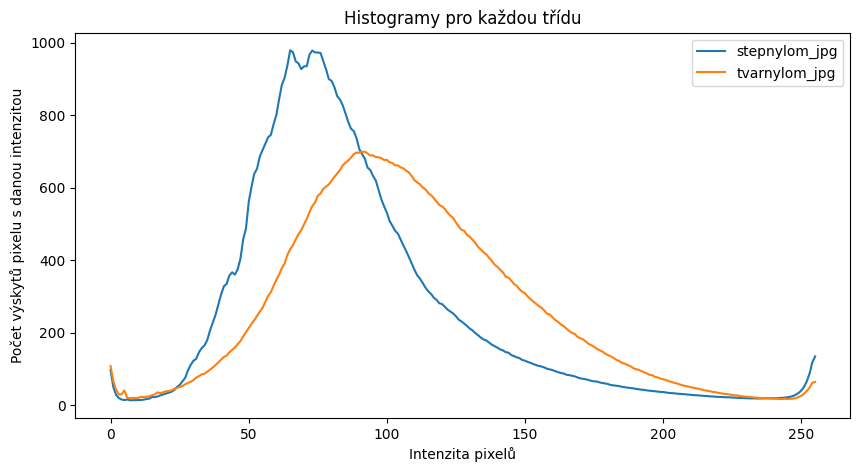

In [28]:
# Vykreslení průměrných histogramů pro každou třídu
plt.figure(figsize=(10, 5))
for label, folder in enumerate(folders.keys()):
    mean_histogram = np.mean(X[y == label], axis=0)
    plt.plot(mean_histogram, label=folder)
plt.title("Histogramy pro každou třídu")
plt.xlabel("Intenzita pixelů")
plt.ylabel("Počet výskytů pixelu s danou intenzitou")
plt.legend()
plt.show()

In [33]:
def load_histograms(file="histograms.csv"):
    df = pd.read_csv(file)
    X = df.iloc[:, 1:-1].values  # Všechny sloupce kromě prvního (filename) a posledního (target)
    y = df.iloc[:, -1].values  # Poslední sloupec (target)
    return X, y

X, y = load_histograms()

# Rozdělení na trénovací a testovací sadu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Trénink Random Forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_preds)
print(f"Random Forest přesnost: {rf_accuracy:.4f}")

# Trénink XGBoost
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_preds)
print(f"XGBoost přesnost: {xgb_accuracy:.4f}")

Random Forest přesnost: 0.9032
XGBoost přesnost: 0.9113
